<a href="https://colab.research.google.com/github/SHayashida/Amanogawa/blob/main/Amanogawa_dark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Setup (Colab) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from skimage.feature import blob_log
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import remove_small_objects, skeletonize
from skimage.measure import label, regionprops
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
import json, math, os, random

np.random.seed(42); random.seed(42)

# ---- I/O (ファイル名の自動解決) ----
IMG_CANDIDATES = ["/content/drive/MyDrive/Colab Notebooks/天の川/IMG_5991.jpg"]
CSV_CANDIDATES = ["/content/drive/MyDrive/Colab Notebooks/天の川/IMG_5991_star_coords.csv"]
IMAGE_PATH = next((f for f in IMG_CANDIDATES if Path(f).exists()), IMG_CANDIDATES[0])
COORDS_CSV = next((f for f in CSV_CANDIDATES if Path(f).exists()), CSV_CANDIDATES[0])

# 天球スケール（任意）：既報の plate scale ≈ 66.96 arcsec/px（必要に応じて変更）
PLATE_SCALE_ARCSEC_PER_PX = 66.959

# ---- 基本ユーティリティ ----
def load_image_gray(path):
    img = Image.open(path).convert("L")
    arr = np.array(img).astype(float)
    H, W = arr.shape
    return arr, (W, H)

def to_unit(x):
    x = x.astype(float)
    x -= x.min()
    d = x.max() - x.min()
    if d == 0: return np.zeros_like(x)
    return x / d

def detect_stars_log(img, max_sigma=6, num_sigma=12, threshold=0.05):
    blobs = blob_log(img, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)
    if len(blobs) == 0:
        return pd.DataFrame(columns=["x","y","r"])
    return pd.DataFrame({"x": blobs[:,1], "y": blobs[:,0], "r": blobs[:,2]})

def load_or_detect_star_points(image, coords_csv, detect_threshold=0.05):
    WCS = None
    H, W = image.shape
    p = Path(coords_csv)
    if p.exists():
        df = pd.read_csv(p)
        print(f"[INFO] loaded coords: {p} (N={len(df)})")
    else:
        df = detect_stars_log(image, threshold=detect_threshold)
        df.to_csv(coords_csv, index=False)
        print(f"[INFO] detected stars by LoG (N={len(df)}), saved -> {coords_csv}")
    # inside-frame only
    m = (df["x"].between(0, W-1)) & (df["y"].between(0, H-1))
    df = df[m].reset_index(drop=True)
    return df[["x","y"]].to_numpy(), df

def boxcount_fractal_on_mask(mask, exp_from=-1.0, exp_to=-2.2, steps=10):
    """True(=1)画素の集合に対するボックスカウント。"""
    Y, X = np.nonzero(mask)
    if len(X) == 0:
        return np.nan, None, None
    Xn = (X - X.min()) / max(1, (X.max() - X.min()))
    Yn = (Y - Y.min()) / max(1, (Y.max() - Y.min()))
    pts = np.column_stack([Xn, Yn])
    eps_list = np.logspace(exp_from, exp_to, steps)
    Ns = []
    for eps in eps_list:
        bins = int(np.ceil(1/eps))
        if bins < 1: bins = 1
        grid = np.floor(pts * bins).astype(int)
        grid[grid==bins] = bins-1
        Ns.append(len(np.unique(grid, axis=0)))
    eps = np.array(eps_list); Ns = np.array(Ns)
    coeff = np.polyfit(np.log(1/eps), np.log(Ns + 1e-9), 1)
    return float(coeff[0]), eps, Ns

def pca_axis_from_density(points, W, H, bins_x=60):
    """2Dヒストグラム重みのPCA。主軸角度(°)と中心を返す。"""
    bins_y = int(bins_x * H / W)
    hist, xedges, yedges = np.histogram2d(points[:,0], points[:,1],
                                          bins=[bins_x, bins_y],
                                          range=[[0,W],[0,H]])
    xc = 0.5*(xedges[1:]+xedges[:-1]); yc = 0.5*(yedges[1:]+yedges[:-1])
    XX, YY = np.meshgrid(xc, yc, indexing='xy')
    w = hist.T
    xw = np.average(XX, weights=w); yw = np.average(YY, weights=w)
    dx = XX - xw; dy = YY - yw
    C = np.array([[np.average(dx*dx, weights=w), np.average(dx*dy, weights=w)],
                  [np.average(dx*dy, weights=w), np.average(dy*dy, weights=w)]])
    vals, vecs = np.linalg.eig(C)
    i = np.argmax(vals); v = vecs[:, i]
    ang = math.degrees(math.atan2(v[1], v[0]))
    # 軸比（楕円リング用の参考）：sqrt(λ_minor/λ_major)
    lam = np.sort(vals)
    axis_ratio_q = math.sqrt(lam[0]/lam[1]) if lam[1] > 0 else 1.0
    return float(ang), (float(xw), float(yw)), float(axis_ratio_q)

def rotate_xy(x, y, center, angle_deg):
    th = math.radians(angle_deg)
    cx, cy = center
    xr =  (x - cx)*math.cos(th) + (y - cy)*math.sin(th)
    yr = -(x - cx)*math.sin(th) + (y - cy)*math.cos(th)
    return xr, yr

def annulus_stats_surface_brightness(img, center, angle_deg=0.0, q=1.0, nbins=30, r_max_px=None):
    """楕円アニュラスで表面輝度の半径プロファイル。q=b/a（0<q<=1）。"""
    H, W = img.shape
    yy, xx = np.mgrid[0:H, 0:W]
    xr, yr = rotate_xy(xx, yy, center, angle_deg)
    if r_max_px is None:
        r_max_px = 0.5 * math.hypot(W, H)
    # 楕円距離 r = sqrt( (xr/a)^2 + (yr/b)^2 ) だが、比のみ必要なので a=1, b=q として定義
    r_ell = np.sqrt((xr)**2 + (yr/q)**2)
    bins = np.linspace(0, r_max_px, nbins+1)
    centers = 0.5*(bins[1:]+bins[:-1])
    mean_sb, std_sb, area = [], [], []
    for i in range(nbins):
        m = (r_ell>=bins[i]) & (r_ell<bins[i+1])
        vals = img[m]
        if vals.size == 0:
            mean_sb.append(np.nan); std_sb.append(np.nan); area.append(0.0)
        else:
            mean_sb.append(float(np.mean(vals)))
            std_sb.append(float(np.std(vals)))
            area.append(float(vals.size))
    return centers, np.array(mean_sb), np.array(std_sb), np.array(area), bins

def annulus_star_counts(points, center, angle_deg=0.0, q=1.0, nbins=30, r_max_px=None):
    """楕円アニュラスごとの星数と面密度（counts/area）。"""
    pts = np.asarray(points)
    if r_max_px is None:
        # 画像の対角の半分を安全に
        r_max_px = 3000.0
    xr, yr = rotate_xy(pts[:,0], pts[:,1], center, angle_deg)
    r_ell = np.sqrt((xr)**2 + (yr/q)**2)
    bins = np.linspace(0, r_max_px, nbins+1)
    centers = 0.5*(bins[1:]+bins[:-1])
    hist, _ = np.histogram(r_ell, bins=bins)
    return centers, hist, bins

[INFO] loaded coords: /content/drive/MyDrive/Colab Notebooks/天の川/IMG_5991_star_coords.csv (N=13733)
IMAGE: /content/drive/MyDrive/Colab Notebooks/天の川/IMG_5991.jpg  size=3024x4032  stars=13733


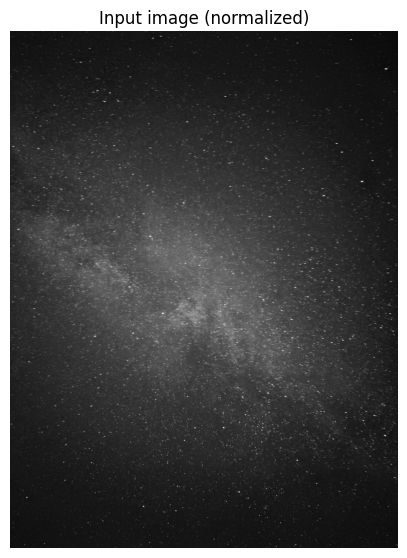

In [ ]:
img, (W, H) = load_image_gray(IMAGE_PATH)
img_u = to_unit(img)                   # 0..1 正規化（明るい=1）
stars_xy, stars_df = load_or_detect_star_points(img, COORDS_CSV, detect_threshold=0.05)

print(f"IMAGE: {IMAGE_PATH}  size={W}x{H}  stars={len(stars_xy)}")
plt.figure(figsize=(5,7))
plt.imshow(img_u, cmap="gray", origin="upper")
plt.title("Input image (normalized)")
plt.axis("off")
plt.show()


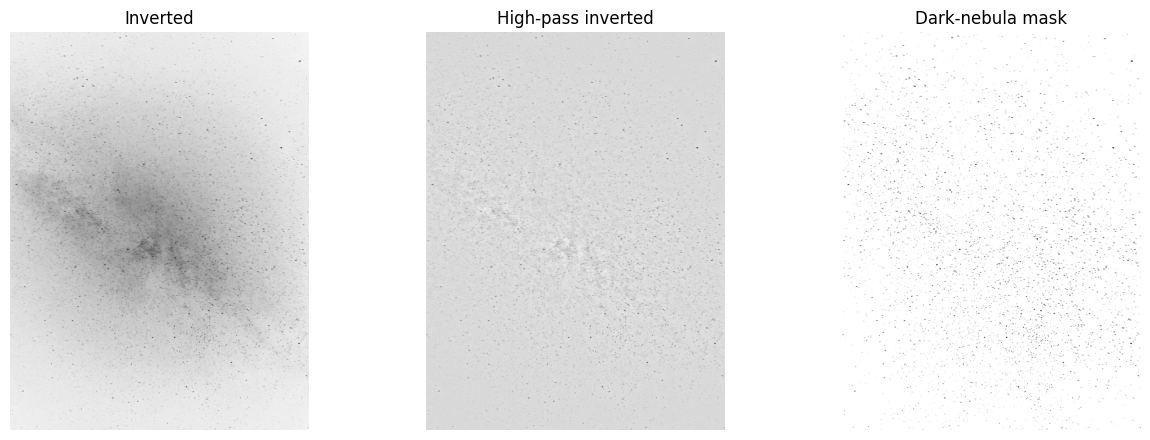

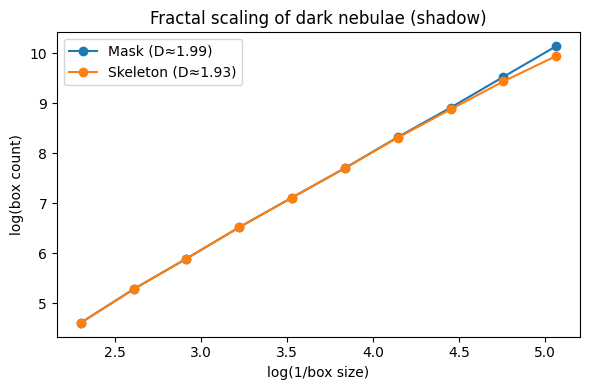

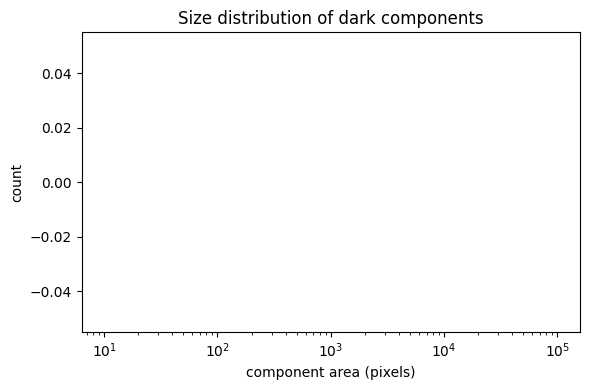

saved: dark_morphology_summary.json


In [ ]:
# --- 画像の反転（暗黒星雲を明るく） ---
inv = 1.0 - img_u

# 大域的勾配を除去（high-pass）：ガウシアン平滑を引き算→再正規化
inv_hp = inv - gaussian_filter(inv, sigma=50)
inv_hp = to_unit(inv_hp)

# --- 自動しきい値で「影」マスク作成（局所適応的：Sauvola） ---
win = 51  # 窓サイズ（奇数）
k = 0.2
th_map = threshold_sauvola(inv_hp, window_size=win, k=k)
mask_dark = inv_hp > th_map

# 微小ノイズ除去（10 px未満を削除）
mask_dark = remove_small_objects(mask_dark, min_size=10)

# 骨格化（オプション：線状の雲筋を抽出）
skeleton = skeletonize(mask_dark)

# --- 可視化 ---
fig, ax = plt.subplots(1,3, figsize=(13,4.5))
ax[0].imshow(inv, cmap="gray"); ax[0].set_title("Inverted")
ax[1].imshow(inv_hp, cmap="gray"); ax[1].set_title("High-pass inverted")
ax[2].imshow(mask_dark, cmap="gray"); ax[2].set_title("Dark-nebula mask")
for a in ax: a.axis("off")
plt.tight_layout(); plt.show()

# --- フラクタル次元（マスク & 骨格） ---
D_mask, eps_m, Ns_m = boxcount_fractal_on_mask(mask_dark, -1.0, -2.2, 10)
D_skel, eps_s, Ns_s = boxcount_fractal_on_mask(skeleton,  -1.0, -2.2, 10)

plt.figure(figsize=(6,4))
plt.plot(np.log(1/eps_m), np.log(Ns_m), "o-", label=f"Mask (D≈{D_mask:.2f})")
plt.plot(np.log(1/eps_s), np.log(Ns_s), "o-", label=f"Skeleton (D≈{D_skel:.2f})")
plt.xlabel("log(1/box size)"); plt.ylabel("log(box count)")
plt.title("Fractal scaling of dark nebulae (shadow)")
plt.legend(); plt.tight_layout(); plt.show()

# --- 面積率・連結成分サイズ分布（参考） ---
lab = label(mask_dark)
props = regionprops(lab)
areas = np.array([p.area for p in props])
area_frac = mask_dark.mean()

plt.figure(figsize=(6,4))
plt.hist(areas, bins=np.logspace(1,5,40))
plt.xscale("log"); plt.xlabel("component area (pixels)"); plt.ylabel("count")
plt.title("Size distribution of dark components")
plt.tight_layout(); plt.show()

# 保存（Zenodo用）
out_dark = {
    "D_dark_mask": None if np.isnan(D_mask) else float(D_mask),
    "D_dark_skeleton": None if np.isnan(D_skel) else float(D_skel),
    "area_fraction": float(area_frac),
    "threshold_params": {"method": "sauvola", "window": win, "k": k},
    "highpass_sigma": 50
}
with open("dark_morphology_summary.json","w") as f:
    json.dump(out_dark, f, indent=2)
print("saved: dark_morphology_summary.json")


principal axis ~ -120.0 deg from x,  center ~ (1443.7, 2110.6),  q≈0.77


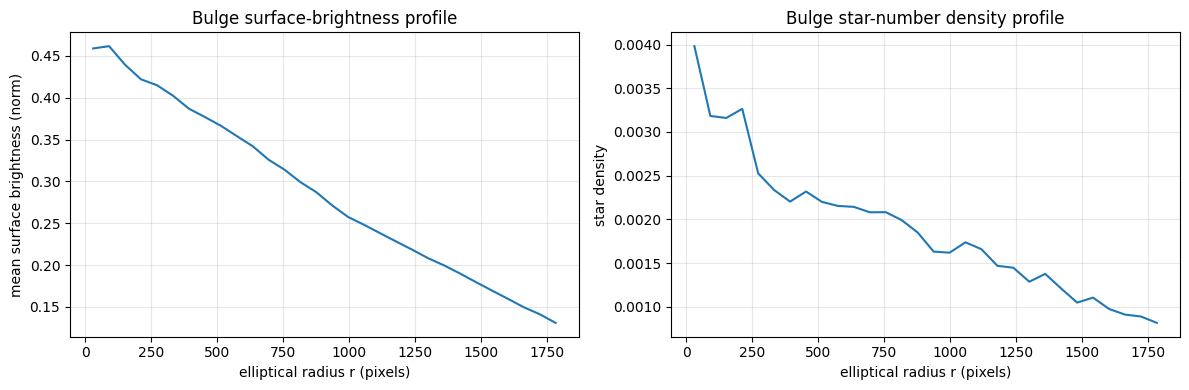

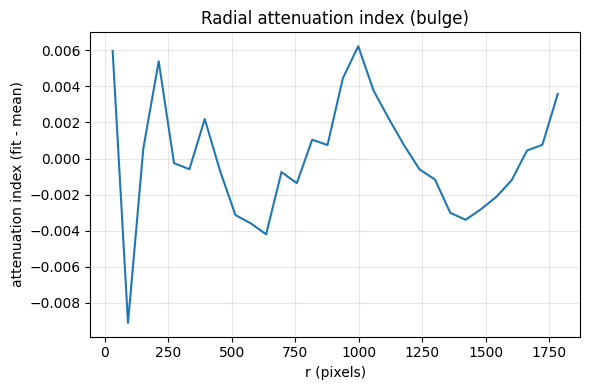

Strongest decline at r ≈ 151.2 px  (~2.81 deg)


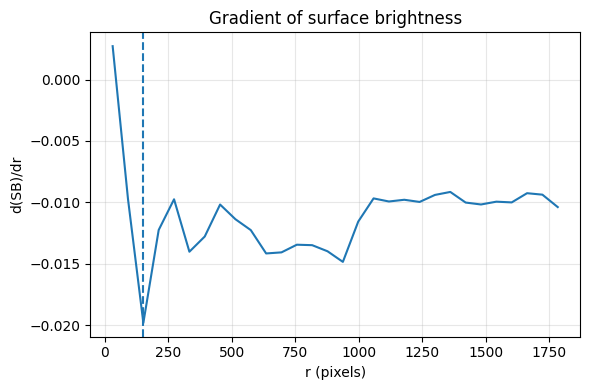

saved: bulge_radial_profiles.csv


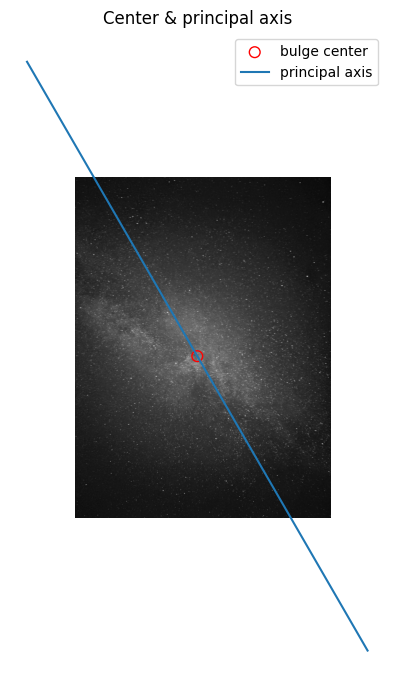

In [ ]:
# --- バルジ中心・主軸の推定（星密度に基づく） ---
ang_deg, center_xy, q_est = pca_axis_from_density(stars_xy, W, H, bins_x=60)
cx, cy = center_xy
print(f"principal axis ~ {ang_deg:.1f} deg from x,  center ~ ({cx:.1f}, {cy:.1f}),  q≈{q_est:.2f}")

# 画像の広域スムージングで「表面輝度場」を作る（星個々の粒状性を和らげる）
img_smooth = gaussian_filter(img_u, sigma=8)

# --- 楕円アニュラスのプロファイル（表面輝度） ---
nbins = 30
r_max_px = min(W,H) * 0.6
r_c_sb, sb_mean, sb_std, sb_area, edges_sb = annulus_stats_surface_brightness(
    img_smooth, center=center_xy, angle_deg=ang_deg, q=q_est, nbins=nbins, r_max_px=r_max_px
)

# --- 楕円アニュラスの星数密度 ---
r_c_st, counts, edges_st = annulus_star_counts(
    stars_xy, center=center_xy, angle_deg=ang_deg, q=q_est, nbins=nbins, r_max_px=r_max_px
)
# 面積はSB側のものを流用（同一bin）
density = counts / np.maximum(sb_area, 1)

# --- プロファイルの図（px & 角距離） ---
arcmin_per_px = PLATE_SCALE_ARCSEC_PER_PX / 60.0
r_deg = r_c_sb * arcmin_per_px / 60.0  # degree

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(r_c_sb, sb_mean, label="surface brightness (mean)")
ax[0].set_xlabel("elliptical radius r (pixels)"); ax[0].set_ylabel("mean surface brightness (norm)")
ax[0].set_title("Bulge surface-brightness profile")
ax[1].plot(r_c_st, density, label="star density (counts/px²)")
ax[1].set_xlabel("elliptical radius r (pixels)"); ax[1].set_ylabel("star density")
ax[1].set_title("Bulge star-number density profile")
for a in ax: a.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# --- 減光インデックス（基準で割る or 差分） ---
# スムーズな基準として低次数多項式/移動平均でフィットし、残差を “attenuation index” と解釈
z = np.polyfit(r_c_sb, sb_mean, deg=3)
sb_fit = np.polyval(z, r_c_sb)
atten_index = (sb_fit - sb_mean)  # 正の値=暗化（期待）

plt.figure(figsize=(6,4))
plt.plot(r_c_sb, atten_index)
plt.xlabel("r (pixels)"); plt.ylabel("attenuation index (fit - mean)")
plt.title("Radial attenuation index (bulge)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# --- 急激な落ち込みの検出（一次差分の極小） ---
grad = np.gradient(sb_mean)
idx_min = np.argmin(grad)  # 最も落ち込みが急な半径
r_drop_px = r_c_sb[idx_min]
r_drop_deg = r_drop_px * arcmin_per_px / 60.0
print(f"Strongest decline at r ≈ {r_drop_px:.1f} px  (~{r_drop_deg:.2f} deg)")

plt.figure(figsize=(6,4))
plt.plot(r_c_sb, grad)
plt.axvline(r_drop_px, ls="--")
plt.xlabel("r (pixels)"); plt.ylabel("d(SB)/dr")
plt.title("Gradient of surface brightness")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# --- 出力（CSV） ---
prof = pd.DataFrame({
    "r_pixels": r_c_sb,
    "r_degrees": r_deg,
    "sb_mean": sb_mean,
    "sb_std": sb_std,
    "ring_area_px2": sb_area,
    "star_counts": counts,
    "star_density_per_px2": density,
    "atten_index": atten_index
})
prof.to_csv("bulge_radial_profiles.csv", index=False)
print("saved: bulge_radial_profiles.csv")

# 参考可視化：楕円リングの中心と主軸を画像上に表示
plt.figure(figsize=(5,7))
plt.imshow(img_u, cmap="gray")
plt.scatter([cx],[cy], s=60, edgecolors="red", facecolors="none", label="bulge center")
L = max(W,H)
x1 = cx - math.cos(math.radians(ang_deg))*L
y1 = cy - math.sin(math.radians(ang_deg))*L
x2 = cx + math.cos(math.radians(ang_deg))*L
y2 = cy + math.sin(math.radians(ang_deg))*L
plt.plot([x1,x2],[y1,y2], label="principal axis")
plt.legend(); plt.axis("off"); plt.title("Center & principal axis")
plt.tight_layout(); plt.show()


Fractal dimension (stars) D_star ≈ 1.67
Fractal dimension (dark mask) D_dark ≈ 1.99 (skeleton 1.93)


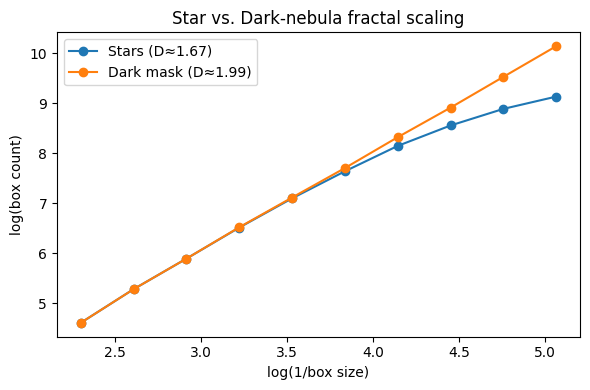

In [ ]:
# 影(D_dark) と 星(D_star) の比較
# 星側フラクタル（ボックスカウント）
def boxcount_fractal_points(points, W, H, exp_from=-1.0, exp_to=-2.2, steps=10):
    X = np.column_stack([points[:,0]/W, points[:,1]/H])
    eps_list = np.logspace(exp_from, exp_to, steps); Ns=[]
    for eps in eps_list:
        bins = int(np.ceil(1/eps))
        grid = np.floor(X*bins).astype(int)
        grid[grid==bins] = bins-1
        Ns.append(len(np.unique(grid, axis=0)))
    eps = np.array(eps_list); Ns = np.array(Ns)
    D = np.polyfit(np.log(1/eps), np.log(Ns+1e-9), 1)[0]
    return float(D), eps, Ns

D_star, e_star, N_star = boxcount_fractal_points(stars_xy, W, H)
print(f"Fractal dimension (stars) D_star ≈ {D_star:.2f}")
print(f"Fractal dimension (dark mask) D_dark ≈ {out_dark['D_dark_mask']:.2f} (skeleton {out_dark['D_dark_skeleton']:.2f})")

plt.figure(figsize=(6,4))
plt.plot(np.log(1/e_star), np.log(N_star), "o-", label=f"Stars (D≈{D_star:.2f})")
plt.plot(np.log(1/eps_m), np.log(Ns_m), "o-", label=f"Dark mask (D≈{out_dark['D_dark_mask']:.2f})")
plt.xlabel("log(1/box size)"); plt.ylabel("log(box count)")
plt.title("Star vs. Dark-nebula fractal scaling")
plt.legend(); plt.tight_layout(); plt.show()
